In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp
from osc_toolkit import *
from models import *
from jitcdde import y, t, jitcdde

In [11]:
import scienceplots

plt.style.use('science')

In [10]:
class mixed_delayed_oscillation(delayed_oscillation):
    def __init__(self, model, delays, params1, params2, consts1, consts2, init_cond):

        # Model and parameters
        self._model = model['model']
        self._delays = delays
        self._params = np.concatenate((params1, params2))
        self._consts = np.concatenate((consts1, consts2))
        self._calc_all = model['calc_all']
        self._init_cond = init_cond
        self.dde = self._model(self._delays)

        # Essential information
        self._species = ['A2', 'S1', 'S2', 'A', 'O']
        self._info = model['info']

        # Experimental data
        self._exp_data = None

    def plot(self, t=10, exp=False, ylim=None, acc=80):
        color = ['purple', 'b', 'lightskyblue', 'r', 'g']

        sol, t = self.simulate(t, acc=acc)
        c = self._calc_all(sol, self._consts, self._params)
        fig, ax = plt.subplots(2, 2, figsize=(7, 5))

        ax[0, 0].plot(t, c[0], label=self._species[0], color=color[0])
        ax[0, 1].plot(t, c[1], label=self._species[1], color=color[1])
        ax[0, 1].plot(t, c[2], label=self._species[2], color=color[2])
        ax[1, 0].plot(t, c[3], label=self._species[3], color=color[3])
        ax[1, 1].plot(t, c[4], label=self._species[4], color=color[4])

        for a in ax.flatten():
            if ylim != None:
                ax.set_ylim(0, ylim)
            a.legend(loc="upper right")
            
        fig.supxlabel('Normalized Time')
        fig.supylabel('Normalized Concentration')
        plt.tight_layout()
        return fig, ax

In [2]:
def delayed_full_two_thiols_model(delays):
    td1, td2 = delays
    alpha1, beta1, theta1, phi1, ep1, delta1, alpha2, beta2, theta2, phi2, ep2, delta2, lam1, m1, lam2, m2 = \
        symbols('alpha1 beta1 theta1 phi1 ep1 delta1 alpha2 beta2 theta2 phi2 ep2 delta2 lam1 m1 lam2 m2')
    
    r = lam2/lam1
    cA2, cS1, cS2, cM1, cM2, cO = y(0), y(1), y(2), y(3), y(4), y(5)
    cM1_d1, cM1_d2 = y(3, t-td1), y(3, t-td2)
    cM2_d1, cM2_d2 = y(4, t-td1), y(4, t-td2)
    cA = 2 * (1 - cA2) - lam1 * (cS1 + cM1) - lam2 * (cS2 + cM2)

    dcA2dt = cO * cA - 1/2 * alpha1 * (cM1_d2 + r * cM2_d2) * cA2 - 1/2 * alpha2 * (1/r * cM1_d2 + cM2_d2) * cA2 - 1/2 * (theta1 + theta2) * cA2
    dcS1dt = 1/2 * theta1/lam1 * cA2 - 1/2 * phi1 * cS1 - 1/4 * (phi1 + phi2) * cS1 + 1/2 * alpha1/lam1 * (cM1_d2 + r * cM2_d2) * cA2 - delta1 * (cS1**m1 - cM1)
    dcS2dt = 1/2 * theta2/lam2 * cA2 - 1/2 * phi2 * cS2 - 1/4 * (phi1 + phi2) * cS2 + 1/2 * alpha2/lam2 * (1/r * cM1_d2 + cM2_d2) * cA2 - delta2 * (cS2**m2 - cM2)
    dcM1dt = delta1 * (cS1**m1 - cM1) - (beta1)/2 * cM1_d1 - 1/4 * (beta1 + beta2) * cM1_d1
    dcM2dt = delta2 * (cS2**m2 - cM2) - (beta2)/2 * cM2_d1 - 1/4 * (beta1 + beta2) * cM2_d1
    dcOdt = ep1 * (1 - cO * cA)
    dde = jitcdde([dcA2dt, dcS1dt, dcS2dt, dcM1dt, dcM2dt, dcOdt], control_pars=[
                  alpha1, beta1, theta1, phi1, ep1, delta1, alpha2, beta2, theta2, phi2, ep2, delta2, lam1, m1, lam2, m2])
    return dde

def calc_all_delayed_full_two_thiols(sol, consts, *params):
    lam1, m1, lam2, m2 = consts
    cA2 = sol[:, 0]
    cS1 = sol[:, 1]
    cS2 = sol[:, 2]
    cM1 = sol[:, 3]
    cM2 = sol[:, 4]
    cO = sol[:, 5]
    cS1_sum = cS1 + cM1
    cS2_sum = cS2 + cM2
    cA = 2 * (1 - cA2) - lam1 * cS1_sum - lam2 * cS2_sum
    return [cA2, cS1_sum, cS2_sum, cA, cO]

delayed_full_two_thiols = {'model': delayed_full_two_thiols_model, 'calc_all': calc_all_delayed_full_two_thiols, 'info': '5*2 parameters, 2*2 constants, 4 species: A2, S1, S2, O'}

In [3]:
file = r'Data_sets/C82_osc_LM.csv'
cmc_82 = 1.56
cmc_92 = 0.29
rext = 11.2
params = [cmc_82, rext]
df_c82LM = input_expdata(file, params)

cA2_tol = 16.300, tau = 1.455


In [4]:
file = r'Data_sets/C92_osc_LM.csv'
cmc_92 = 0.29
rext = 11.2
params = [cmc_92, rext]
df_c92LM = input_expdata(file, params)

cA2_tol = 15.180, tau = 1.355


The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [4.50370500e-03 5.89633333e-04 1.99099259e+00]
Initial condition is set as [0, 0, 0, 0]
Generating, compiling, and loading C code.


clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]
ld: warning: duplicate -rpath '/Users/zhihengzhang/anaconda3/lib' ignored


Using default integration parameters.


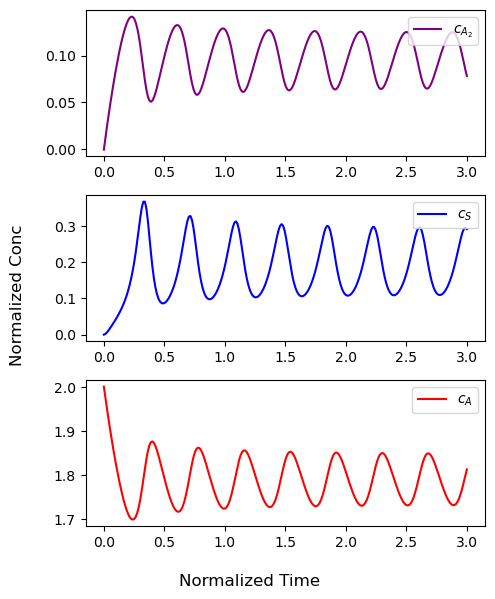

In [6]:
#C82 parameters
rs_ac, rds_ac, rs, rds, ro, rm = 670, 410, 10, 210, 1e4, 1e4
rext = 11.2
lam, m = cmc_82/15, 2
td1, td2 = 0.02, 0.02

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm / rext
params1 = [ 300,  60,   3,  50      , 892.85714286, 892.85714286]
consts1 = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0, 0, 0])
delayed_C82 = delayed_oscillation(delayed_full_4vars, delay=delay, params=params1, consts=consts1, init_cond=init_cond)
delayed_C82.add_exp_data(df_c82LM)

#The vars in the ODEs are cA2, cS, cO. Which is different from the experiment data. The initial conditions are set manually.
delayed_C82.set_init_cond([0, 0, 0, 0])

fig_82, axes_82 = delayed_C82.plot(nvars=3, t=3)

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.00535852 0.00347245 1.98928295]
Initial condition is set as [0, 0, 0, 0]
Generating, compiling, and loading C code.


clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]
ld: warning: duplicate -rpath '/Users/zhihengzhang/anaconda3/lib' ignored


Using default integration parameters.


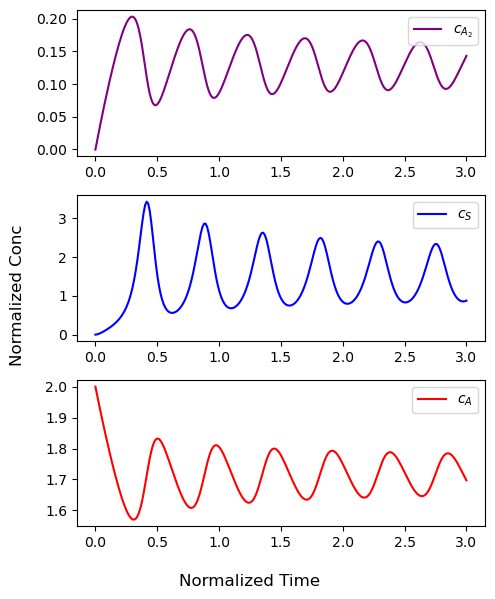

In [7]:
#C92 parameters
rs_ac, rds_ac, rs, rds, ro, rm = 310, 415,  15, 370, 1e4, 1e4
rext = 11.2
lam, m = cmc_92/15, 2
td1, td2 = 0.02, 0.02

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm / rext
params2 = [ 10,  30,   1.5,  40, 892.85714286, 892.85714286]
consts2 = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0, 0, 0])
delayed_C92 = delayed_oscillation(delayed_full_4vars, delay=delay, params=params2, consts=consts2, init_cond=init_cond)
delayed_C92.add_exp_data(df_c92LM)

#The vars in the ODEs are cA2, cS, cO. Which is different from the experiment data. The initial conditions are set manually.
delayed_C92.set_init_cond([0, 0, 0, 0])

fig_92, axes_92 = delayed_C92.plot(nvars=3, t=3)

Generating, compiling, and loading C code.


clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]
ld: warning: duplicate -rpath '/Users/zhihengzhang/anaconda3/lib' ignored


Using default integration parameters.


/Users/zhihengzhang/Documents/01_Research/03_Lab-SPF/Chemical_Oscillation_Model/osc_toolkit.py:285: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


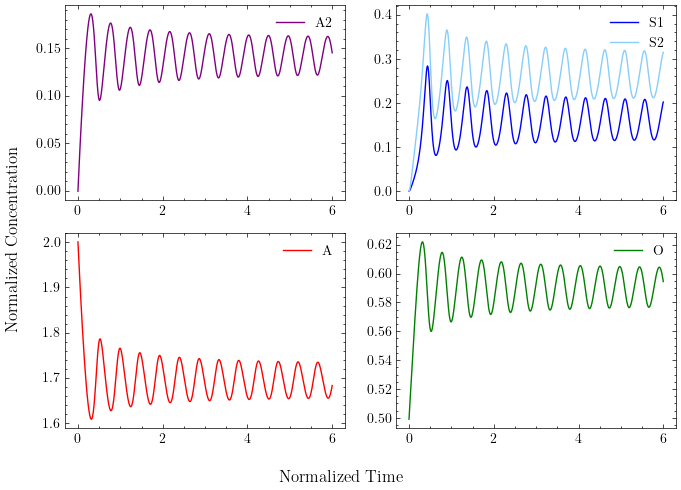

In [12]:
params1 = [ 300,  60,   3,  50      , 892.85714286, 892.85714286]
params2 = [ 10,  30,   1.5,  40, 892.85714286, 892.85714286]
delay = [0.02, 0.02]
init_cond = [0, 0, 0, 0, 0, 0]
mixed_8292 = mixed_delayed_oscillation(delayed_full_two_thiols, delay, params1, params2, consts1, consts2, init_cond)
fig_mix, axes_mix = mixed_8292.plot(t=6, acc=200)

In [13]:
df_mix89LM = pd.read_csv(r'Data_sets/C82+C92_osc_LM.csv')

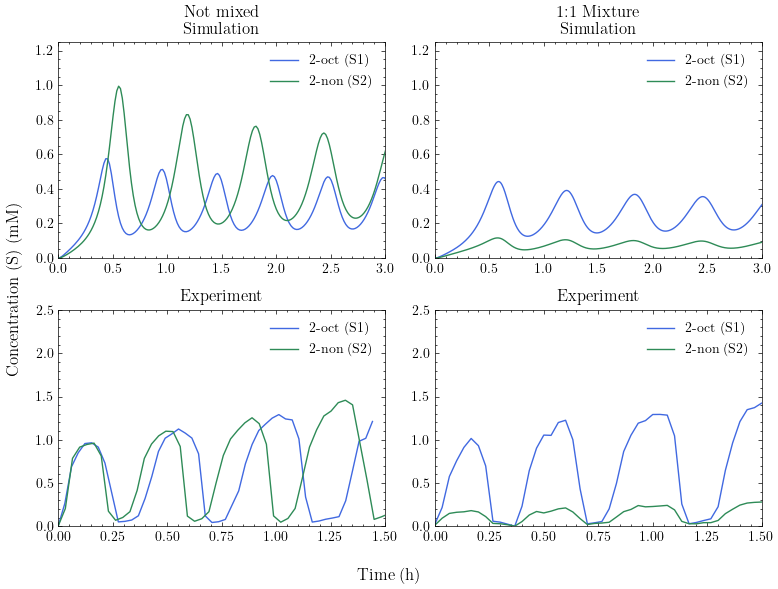

In [14]:
tau = 1.34
t_mix = axes_mix[0, 1].get_lines()[0].get_xdata() * tau
cS1_mix = axes_mix[0, 1].get_lines()[0].get_ydata() * cmc_82
cS2_mix = axes_mix[0, 1].get_lines()[1].get_ydata() * cmc_92
t1 = axes_82[1].get_lines()[0].get_xdata() * tau
t2 = axes_92[1].get_lines()[0].get_xdata() * tau
cS1 = axes_82[1].get_lines()[0].get_ydata() * cmc_82
cS2 = axes_92[1].get_lines()[0].get_ydata() * cmc_92

t1_exp = df_c82LM['tS'] * tau
t2_exp = df_c92LM['tS'] * tau
cS1_exp = df_c82LM['cS'] * cmc_82
cS2_exp = df_c92LM['cS'] * cmc_92
tmix_exp = df_mix89LM['tS']
cS1_mix_exp = df_mix89LM['cS28']
cS2_mix_exp = df_mix89LM['cS29']

fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax[0, 0].plot(t1, cS1, label='2-oct (S1)', color='royalblue')
ax[0, 0].plot(t2, cS2, label='2-non (S2)', color='seagreen')
ax[0, 1].plot(t_mix, cS1_mix, label='2-oct (S1)', color='royalblue')
ax[0, 1].plot(t_mix, cS2_mix, label='2-non (S2)', color='seagreen')


ax[1, 0].plot(t1_exp, cS1_exp, label='2-oct (S1)', color='royalblue')
ax[1, 1].plot(tmix_exp, cS1_mix_exp, label='2-oct (S1)', color='royalblue')
ax[1, 1].plot(tmix_exp, cS2_mix_exp, label='2-non (S2)', color='seagreen')
ax[1, 0].plot(t2_exp, cS2_exp, label='2-non (S2)', color='seagreen')

ax[0, 0].set_title('Not mixed \n Simulation')
ax[0, 1].set_title('1:1 Mixture \n Simulation')

ax[1, 0].set_title('Experiment')
ax[1, 1].set_title('Experiment')

for a in ax[0]:
    a.set_xlim(0, 3)
    a.set_ylim(0, 1.25)

for a in ax[1]:
    a.set_xlim(0, 1.5)
    a.set_ylim(0, 2.5)

for a in ax.flatten():
    a.legend(loc="upper right")

fig.supxlabel('Time (h)')
fig.supylabel('Concentration (S) (mM)')
plt.tight_layout()

fig.savefig('figs/mix.png', dpi=300, bbox_inches='tight')

In [35]:
def input_expdata(files: str, params: list|np.ndarray) -> pd.DataFrame :
    df = pd.read_csv(files)
    cmc, rext = params
    col_titles = ['tA2', 'cA2', 'tS', 'cS', 'tA', 'cA']
    df.columns = col_titles[:len(df.columns)]
    
    cA2_tol = df.loc[0, 'cA2'] + df.loc[0, 'cA'] / 2 if 'cA' in df.columns else df.loc[0, 'cA2']
    tau = cA2_tol / rext

    df['cA2'] /= cA2_tol
    if 'cA' in df.columns:
        df['cA'] /= cA2_tol
    df['cS'] /= cmc
    df['tA2'] /= tau
    df['tS'] /= tau
    if 'tA' in df.columns:
        df['tA'] /= tau
    
    return df

In [36]:
def full_two_thiols_model(t, vars, params):
    cA2, cS1, cS2, cO = vars
    alpha1, beta1, theta1, phi1, ep1, alpha2, beta2, theta2, phi2, ep2, lam1, m1, lam2, m2 = params
    
    r = lam2/lam1
    cM1 = cS1**m1
    cM2 = cS2**m2

    cA = 2 * (1 - cA2) - lam1 * (cS1 + cM1) - lam2 * (cS2 + cM2)

    dcA2dt = cO * cA - 1/2 * (theta1 + theta2) * cA2 - 1/2 * alpha1 * (cM1 + r * cM2) * cA2 - 1/2 * alpha2 * (1/r * cM1 + cM2) * cA2
    dcS1dt = 1/2 * theta1/lam1 * cA2 - phi1 * cS1 + 1/2 * alpha1/lam1 * (cM1 + r * cM2) * cA2 - beta1 * cM1
    dcS2dt = 1/2 * theta2/lam2 * cA2 - phi2 * cS2 + 1/2 * alpha2/lam2 * (1/r * cM1 + cM2) * cA2 - beta2 * cM2
    dcOdt = ep1 * (1 - cO * cA)

    return dcA2dt, dcS1dt, dcS2dt, dcOdt

def calc_all_full_two_thiols(sol, consts, *params):
    lam1, m1, lam2, m2 = consts
    cA2, cS1, cS2, cO = sol.y
    cS1_sum = cS1 + cS1**m1
    cS2_sum = cS2 + cS2**m2
    cA = 2 * (1 - cA2) - lam1 * cS1_sum - lam2 * cS2_sum
    return [cA2, cS1_sum, cS2_sum, cA, cO]

full_two_thiols = {'model': full_two_thiols_model, 'calc_all': calc_all_full_two_thiols, 'info': '5*2 parameters, 2*2 constants, 4 species: A2, S1, S2, O'}

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [4.50370500e-03 5.89633333e-04 1.99099259e+00]
Initial condition is set as [0.01, 0, 0]


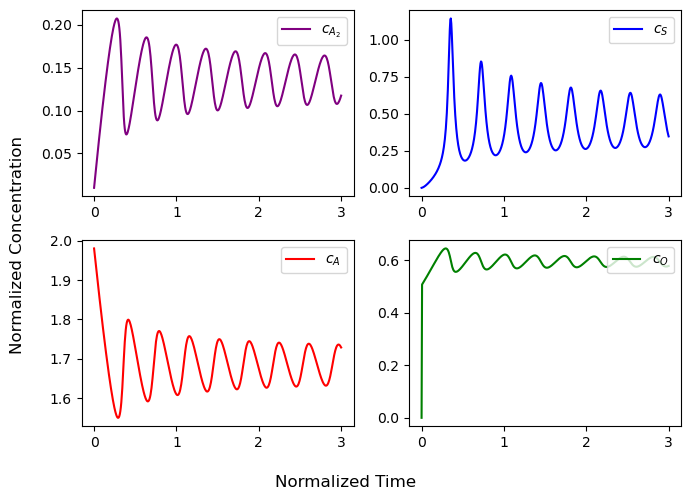

In [149]:
#C82 parameters
rs_ac, rds_ac, rs, rds, ro = 670, 410, 15, 210, 1e4
rext = 11.2
cmc_82 = 1.56
cmc_92 = 0.29
lam, m = cmc_82/15, 2

#Definition of the model
alpha, beta, theta, phi, ep = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext
params1 = np.array([alpha, beta, theta, phi, ep])
consts1 = np.array([lam, m])
init_cond = np.array([0, 0, 0])
model_C82 = oscillation(full_FTC_first_order, params=params1, consts=consts1, init_cond=init_cond)
model_C82.add_exp_data(df_c82LM)

#The vars in the ODEs are cA2, cS, cO. Which is different from the experiment data. The initial conditions are set manually.
model_C82.set_init_cond([0.01, 0, 0])

fig, axes = model_C82.plot(t=3)

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.00535852 0.00347245 1.98928295]
Initial condition is set as [0.01, 0, 0]


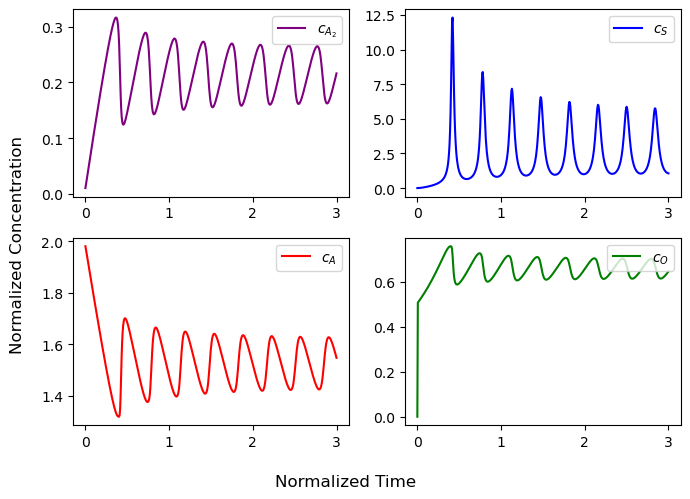

In [150]:
#C92 parameters
rs_ac, rds_ac, rs, rds, ro = 38,   330 ,    4  ,   140, 1e4
rext = 11.2
lam, m = cmc_92/15, 2

#Definition of the model
alpha, beta, theta, phi, ep = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext
params2 = np.array([alpha, beta, theta, phi, ep])
consts2 = np.array([lam, m])
init_cond = np.array([0, 0, 0])
model_C92 = oscillation(full_FTC_first_order, params=params2, consts=consts2, init_cond=init_cond)
model_C92.add_exp_data(df_c92LM)

#The vars in the ODEs are cA2, cS, cO. Which is different from the experiment data. The initial conditions are set manually.
model_C92.set_init_cond([0.01, 0, 0])

fig, axes = model_C92.plot(t=3)

(<Figure size 700x500 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

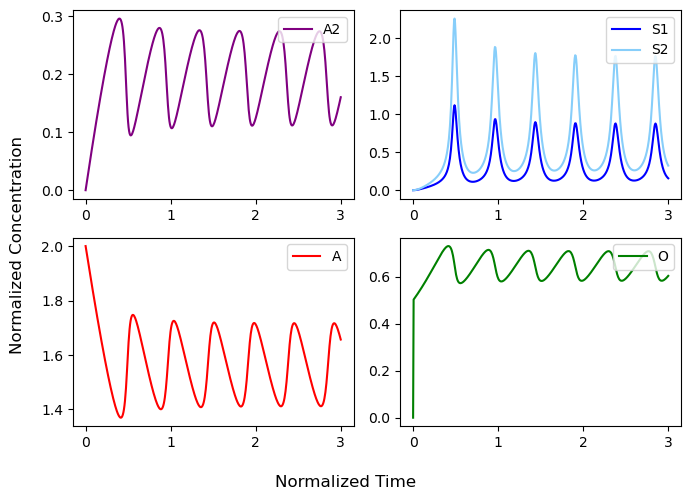

In [151]:
init_cond = [0, 0, 0, 0]
mixed_8292_nondelay = mixed_oscillation(full_two_thiols, params1, params2, consts1, consts2, init_cond)
mixed_8292_nondelay.plot(t=3)